In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch import optim
from tqdm import trange, tqdm_notebook
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import model_selection as ms
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
dataset = fetch_openml('mnist_784')
x = np.array(dataset['data'])
y = np.array(dataset['target'], dtype='int32')
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25, random_state=1)

In [5]:
print(type(x_train))

<class 'numpy.ndarray'>


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, input):
        input = F.relu(self.l1(input))
        input = F.log_softmax(self.l2(input), dim=1)
        return input

In [7]:
EPOCHS = 5
net = Net()
opt = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    i = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        opt.zero_grad()
        output = net(x)
        #  https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
        loss = F.nll_loss(output, y)
        loss.backward()
        opt.step()
    print(loss)

tensor(0.2212, grad_fn=<NllLossBackward>)
tensor(0.1241, grad_fn=<NllLossBackward>)
tensor(0.1053, grad_fn=<NllLossBackward>)
tensor(0.0127, grad_fn=<NllLossBackward>)
tensor(0.0120, grad_fn=<NllLossBackward>)


In [8]:
layer = net.l1.state_dict()
print(layer['weight'])
print(layer['bias'].shape)

tensor([[ 0.0285,  0.0181, -0.0120,  ...,  0.0068,  0.0357,  0.0165],
        [ 0.0348,  0.0141, -0.0212,  ..., -0.0004, -0.0079,  0.0264],
        [ 0.0096, -0.0202, -0.0322,  ..., -0.0338,  0.0045, -0.0257],
        ...,
        [ 0.0015,  0.0157, -0.0214,  ..., -0.0176, -0.0209, -0.0306],
        [-0.0096,  0.0152, -0.0346,  ..., -0.0126,  0.0276, -0.0105],
        [ 0.0206,  0.0177, -0.0070,  ...,  0.0112, -0.0338,  0.0350]])
torch.Size([128])


In [9]:
total = 0
correct = 0

with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        correct += int(torch.sum(y == torch.argmax(output, axis = 1)))
        total += batch_size

print(f"Accuracy: {correct/total * 100}%")

Accuracy: 97.47713414634146%


In [10]:
outputs = []
with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        outputs.extend(list(torch.max(output, 1)[0]))
outputs = np.array(outputs)

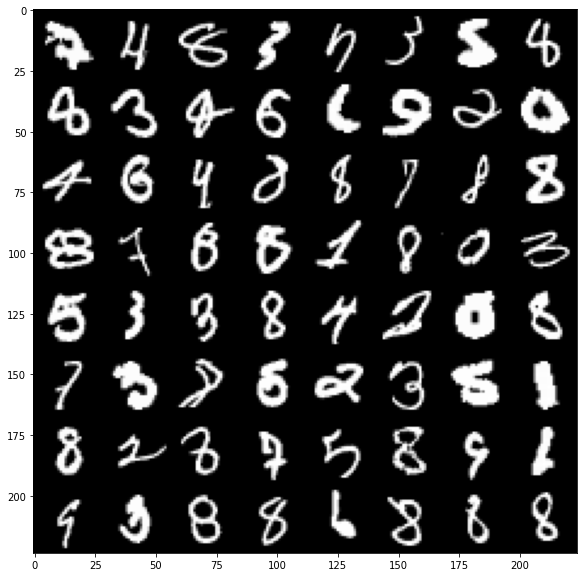

In [11]:
sorted_list = sorted(list(zip(outputs, range(outputs.shape[0]))))
x_bad = x_train[[x[1] for x in sorted_list[:64]]].reshape(8, 28*8, 28)

# let's take a look at the most weird image
plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate(x_bad, axis=1), cmap='gray')